In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR


In [2]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Augmentation: Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4), # Augmentation: Randomly crop images with padding
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # Normalize with CIFAR-10 mean & std
])

# Load CIFAR-10 training set with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split training data into train and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Load CIFAR-10 test set
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders for each split
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].


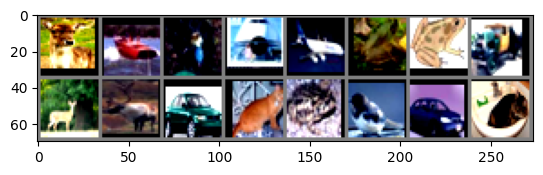

deer ship bird airplane airplane frog frog truck deer deer automobile cat frog bird automobile cat


In [3]:
# Function to display a grid of sample images with labels
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get some random training images and display them
data_iter = iter(train_loader)
images, labels = next(data_iter)
class_names = train_dataset.classes

# Display images in a grid
imshow(torchvision.utils.make_grid(images[:16]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(16)))


## Implementing ResNet-18

In [4]:
# Define a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
# Define ResNet-18 using residual blocks
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [6]:
# Instantiate the model and print the summary
model = ResNet18(num_classes=10)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [7]:
# Check and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If CUDA is available, print GPU details
if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Instantiate the model and move it to the chosen device
model = ResNet18(num_classes=10).to(device)

# Print the summary (for CIFAR-10, input size is 3x32x32)
summary(model, (3, 32, 32), device=str(device))

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
     ResidualBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-1

In [8]:
# Define training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

In [9]:
# Initialize model, criterion, and optimizer
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [10]:
# Hyperparameters
num_epochs = 10

In [12]:
# Initialize lists to store losses and accuracies per epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")

Epoch 1/10
Epoch 1 - Train Loss: 2.0879, Train Accuracy: 27.55%
Epoch 1 - Val Loss: 1.6516, Val Accuracy: 39.06%
Highest Train Accuracy so far: 27.55%
Highest Val Accuracy so far: 39.06%

Epoch 2/10
Epoch 2 - Train Loss: 1.5632, Train Accuracy: 42.23%
Epoch 2 - Val Loss: 1.4623, Val Accuracy: 46.01%
Highest Train Accuracy so far: 42.23%
Highest Val Accuracy so far: 46.01%

Epoch 3/10
Epoch 3 - Train Loss: 1.3311, Train Accuracy: 52.02%
Epoch 3 - Val Loss: 1.2765, Val Accuracy: 53.88%
Highest Train Accuracy so far: 52.02%
Highest Val Accuracy so far: 53.88%

Epoch 4/10
Epoch 4 - Train Loss: 1.1323, Train Accuracy: 59.82%
Epoch 4 - Val Loss: 1.1076, Val Accuracy: 60.98%
Highest Train Accuracy so far: 59.82%
Highest Val Accuracy so far: 60.98%

Epoch 5/10
Epoch 5 - Train Loss: 0.9913, Train Accuracy: 64.97%
Epoch 5 - Val Loss: 1.0713, Val Accuracy: 63.19%
Highest Train Accuracy so far: 64.97%
Highest Val Accuracy so far: 63.19%

Epoch 6/10
Epoch 6 - Train Loss: 0.8674, Train Accuracy: 69.

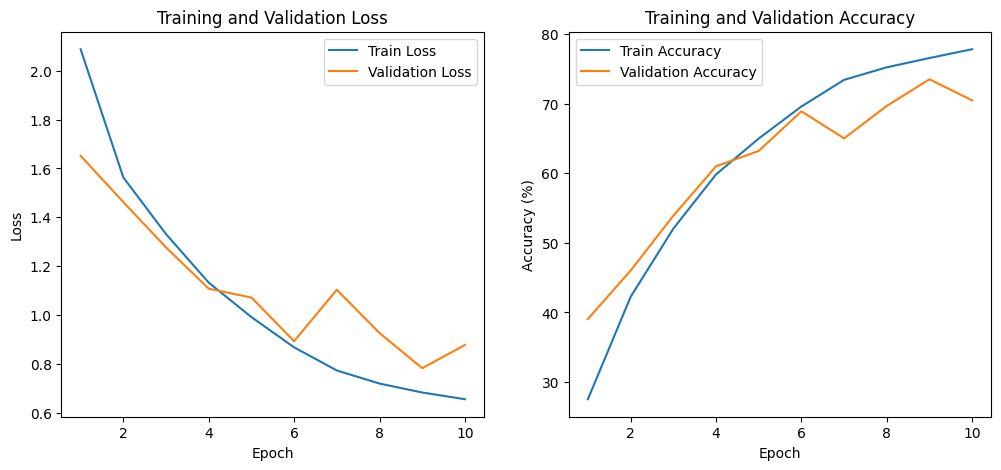

In [13]:
# Plot training/validation accuracy and loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

#### model 2

In [11]:
# Hyperparameters
num_epochs = 20          # Increased epochs for more training cycles
learning_rate = 0.01     # Reduced learning rate for more gradual learning
batch_size = 128         # Increased batch size
weight_decay = 1e-4      # Weight decay for regularization

In [12]:
# Re-define data loaders with updated batch size
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model, criterion, optimizer, and scheduler
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decrease LR by 0.1 every 5 epochs


In [16]:
# Training and validation tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")


Epoch 1/20
Epoch 1 - Train Loss: 1.5441, Train Accuracy: 43.35%
Epoch 1 - Val Loss: 1.3574, Val Accuracy: 51.78%
Highest Train Accuracy so far: 43.35%
Highest Val Accuracy so far: 51.78%

Epoch 2/20
Epoch 2 - Train Loss: 1.0548, Train Accuracy: 62.37%
Epoch 2 - Val Loss: 0.9239, Val Accuracy: 67.34%
Highest Train Accuracy so far: 62.37%
Highest Val Accuracy so far: 67.34%

Epoch 3/20
Epoch 3 - Train Loss: 0.8039, Train Accuracy: 71.63%
Epoch 3 - Val Loss: 0.7607, Val Accuracy: 73.22%
Highest Train Accuracy so far: 71.63%
Highest Val Accuracy so far: 73.22%

Epoch 4/20
Epoch 4 - Train Loss: 0.6699, Train Accuracy: 76.50%
Epoch 4 - Val Loss: 0.7215, Val Accuracy: 75.05%
Highest Train Accuracy so far: 76.50%
Highest Val Accuracy so far: 75.05%

Epoch 5/20
Epoch 5 - Train Loss: 0.5805, Train Accuracy: 79.76%
Epoch 5 - Val Loss: 0.6266, Val Accuracy: 78.43%
Highest Train Accuracy so far: 79.76%
Highest Val Accuracy so far: 78.43%

Epoch 6/20
Epoch 6 - Train Loss: 0.4215, Train Accuracy: 85.

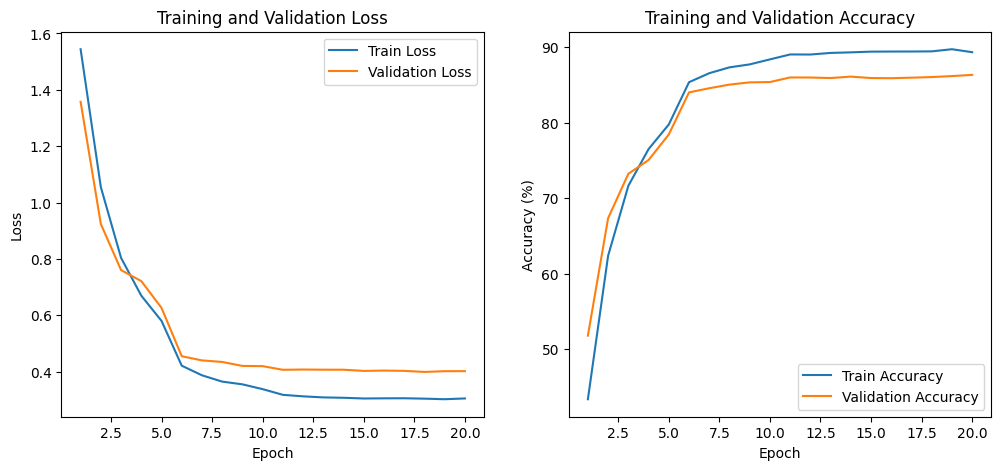

In [17]:
# Plot training/validation accuracy and loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Hyperparameters
num_epochs = 30          # Increased epochs for more training cycles
learning_rate = 0.01    
batch_size = 128         
weight_decay = 1e-4      

In [12]:
# Re-define data loaders with updated batch size
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model, criterion, optimizer, and scheduler
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=30, gamma=0.05)  # Decrease LR by 0.1 every 5 epochs

In [13]:
# Training and validation tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")


Epoch 1/30
Epoch 1 - Train Loss: 1.5021, Train Accuracy: 44.42%
Epoch 1 - Val Loss: 1.5048, Val Accuracy: 49.70%
Highest Train Accuracy so far: 44.42%
Highest Val Accuracy so far: 49.70%

Epoch 2/30
Epoch 2 - Train Loss: 1.0268, Train Accuracy: 63.40%
Epoch 2 - Val Loss: 0.9792, Val Accuracy: 65.45%
Highest Train Accuracy so far: 63.40%
Highest Val Accuracy so far: 65.45%

Epoch 3/30
Epoch 3 - Train Loss: 0.8060, Train Accuracy: 71.38%
Epoch 3 - Val Loss: 0.8435, Val Accuracy: 70.31%
Highest Train Accuracy so far: 71.38%
Highest Val Accuracy so far: 70.31%

Epoch 4/30
Epoch 4 - Train Loss: 0.6744, Train Accuracy: 76.31%
Epoch 4 - Val Loss: 0.7808, Val Accuracy: 73.67%
Highest Train Accuracy so far: 76.31%
Highest Val Accuracy so far: 73.67%

Epoch 5/30
Epoch 5 - Train Loss: 0.5779, Train Accuracy: 79.71%
Epoch 5 - Val Loss: 0.7169, Val Accuracy: 76.20%
Highest Train Accuracy so far: 79.71%
Highest Val Accuracy so far: 76.20%

Epoch 6/30
Epoch 6 - Train Loss: 0.5215, Train Accuracy: 81.

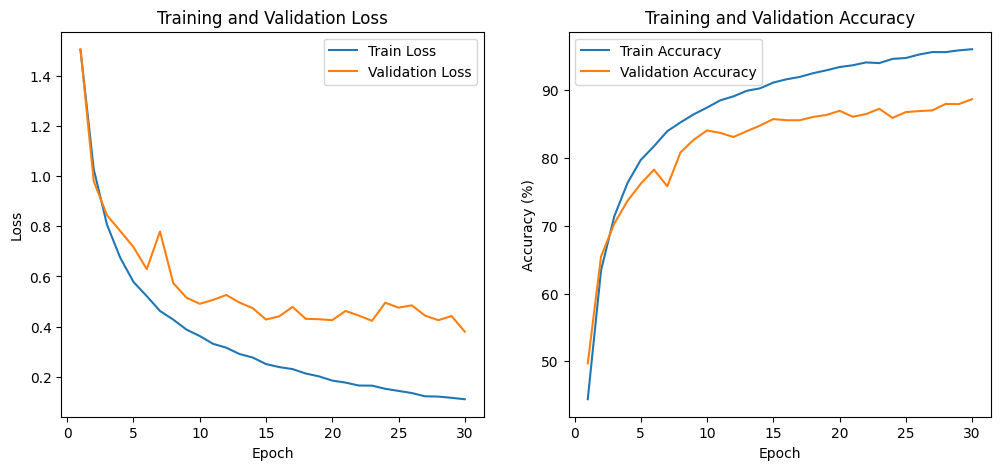

In [14]:
# Plot training/validation accuracy and loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [30]:
summary(model, (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
     ResidualBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Implementing MobileNet

In [22]:

# Define depthwise separable convolution block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise Convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        # Pointwise Convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x

In [23]:
# Define MobileNet architecture
class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # Define the layers as (in_channels, out_channels, stride)
        self.ds_layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            *[DepthwiseSeparableConv(512, 512, stride=1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),
        )
        # Global average pooling and fully connected layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.ds_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [24]:
# Instantiate the model and print the summary
model = MobileNet(num_classes=10).to(device)
print(model)

MobileNet(
  (initial_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ds_layers): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (

In [25]:
# Re-define the data loader with the appropriate batch size
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize MobileNet model, criterion, optimizer, and scheduler
model = MobileNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)  # Decrease LR by 0.01 every 5 epochs


In [26]:
# Training and validation tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

# Training loop for MobileNet
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")


Epoch 1/20
Epoch 1 - Train Loss: 1.9073, Train Accuracy: 27.70%
Epoch 1 - Val Loss: 1.6091, Val Accuracy: 38.99%
Highest Train Accuracy so far: 27.70%
Highest Val Accuracy so far: 38.99%

Epoch 2/20
Epoch 2 - Train Loss: 1.5614, Train Accuracy: 42.05%
Epoch 2 - Val Loss: 1.4884, Val Accuracy: 45.28%
Highest Train Accuracy so far: 42.05%
Highest Val Accuracy so far: 45.28%

Epoch 3/20
Epoch 3 - Train Loss: 1.4176, Train Accuracy: 48.04%
Epoch 3 - Val Loss: 1.3256, Val Accuracy: 51.61%
Highest Train Accuracy so far: 48.04%
Highest Val Accuracy so far: 51.61%

Epoch 4/20
Epoch 4 - Train Loss: 1.2877, Train Accuracy: 53.33%
Epoch 4 - Val Loss: 1.2561, Val Accuracy: 54.73%
Highest Train Accuracy so far: 53.33%
Highest Val Accuracy so far: 54.73%

Epoch 5/20
Epoch 5 - Train Loss: 1.1822, Train Accuracy: 57.32%
Epoch 5 - Val Loss: 1.1193, Val Accuracy: 58.97%
Highest Train Accuracy so far: 57.32%
Highest Val Accuracy so far: 58.97%

Epoch 6/20
Epoch 6 - Train Loss: 1.0887, Train Accuracy: 61.

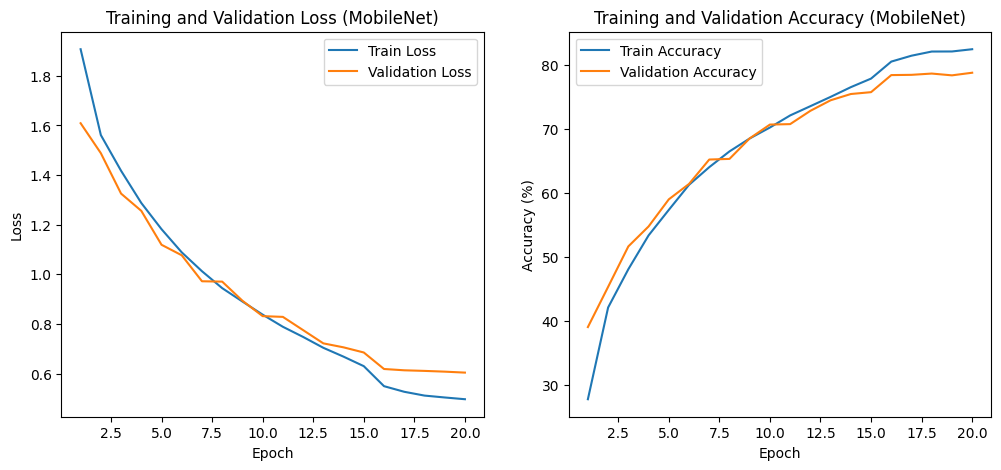

In [27]:
# Plot training/validation accuracy and loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MobileNet)')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (MobileNet)')
plt.legend()

plt.show()

### Model 2

In [28]:
import torchvision.transforms as transforms

# Enhanced data augmentation with rotation and color jitter
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 training set with updated transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split training data into train and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified


In [29]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # Define the layers as (in_channels, out_channels, stride)
        self.ds_layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            *[DepthwiseSeparableConv(512, 512, stride=1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),
        )
        # Global average pooling, dropout, and fully connected layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.ds_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout before the fully connected layer
        x = self.fc(x)
        return x


In [30]:
# Initialize the updated MobileNet model, criterion, optimizer, and scheduler
model = MobileNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

# Training and validation loop (reuse previous code for the train and validate functions)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")


Epoch 1/20
Epoch 1 - Train Loss: 1.9915, Train Accuracy: 25.08%
Epoch 1 - Val Loss: 1.7252, Val Accuracy: 34.69%
Highest Train Accuracy so far: 25.08%
Highest Val Accuracy so far: 34.69%

Epoch 2/20
Epoch 2 - Train Loss: 1.6756, Train Accuracy: 37.58%
Epoch 2 - Val Loss: 1.5568, Val Accuracy: 43.55%
Highest Train Accuracy so far: 37.58%
Highest Val Accuracy so far: 43.55%

Epoch 3/20
Epoch 3 - Train Loss: 1.5353, Train Accuracy: 43.89%
Epoch 3 - Val Loss: 1.4972, Val Accuracy: 46.03%
Highest Train Accuracy so far: 43.89%
Highest Val Accuracy so far: 46.03%

Epoch 4/20
Epoch 4 - Train Loss: 1.4171, Train Accuracy: 48.63%
Epoch 4 - Val Loss: 1.3753, Val Accuracy: 50.41%
Highest Train Accuracy so far: 48.63%
Highest Val Accuracy so far: 50.41%

Epoch 5/20
Epoch 5 - Train Loss: 1.3238, Train Accuracy: 52.48%
Epoch 5 - Val Loss: 1.2796, Val Accuracy: 53.61%
Highest Train Accuracy so far: 52.48%
Highest Val Accuracy so far: 53.61%

Epoch 6/20
Epoch 6 - Train Loss: 1.2517, Train Accuracy: 55.

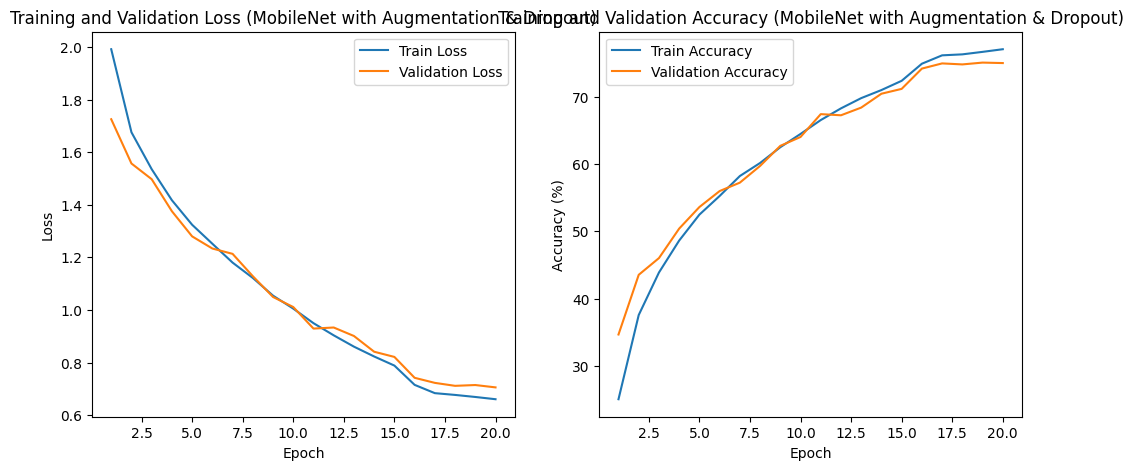

In [31]:
# Plot training and validation results as before
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MobileNet with Augmentation & Dropout)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (MobileNet with Augmentation & Dropout)')
plt.legend()

plt.show()

## Implementing Inception

In [15]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.ReLU()
        )
        
        # 1x1 -> 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 1x1 -> 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.ReLU()
        )
        
        # 3x3 max pooling -> 1x1 convolution branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Apply each branch and concatenate results
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)
        return outputs


In [16]:
class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Inception modules
        self.inception1 = InceptionModule(64, 32, 32, 64, 16, 32, 32)
        self.inception2 = InceptionModule(160, 64, 48, 96, 24, 64, 64)
        
        # Down-sample with a max pool layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Additional Inception modules
        self.inception3 = InceptionModule(288, 64, 64, 128, 32, 64, 64)
        self.inception4 = InceptionModule(320, 128, 80, 160, 48, 96, 96)
        
        # Global average pooling and dropout
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [34]:
# Initialize the InceptionNet model, criterion, optimizer, and scheduler
model = InceptionNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

# Training and validation loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")


Epoch 1/20
Epoch 1 - Train Loss: 2.2992, Train Accuracy: 11.55%
Epoch 1 - Val Loss: 2.2848, Val Accuracy: 16.39%
Highest Train Accuracy so far: 11.55%
Highest Val Accuracy so far: 16.39%

Epoch 2/20
Epoch 2 - Train Loss: 2.1420, Train Accuracy: 18.82%
Epoch 2 - Val Loss: 2.0110, Val Accuracy: 22.28%
Highest Train Accuracy so far: 18.82%
Highest Val Accuracy so far: 22.28%

Epoch 3/20
Epoch 3 - Train Loss: 1.9769, Train Accuracy: 23.35%
Epoch 3 - Val Loss: 1.9274, Val Accuracy: 24.75%
Highest Train Accuracy so far: 23.35%
Highest Val Accuracy so far: 24.75%

Epoch 4/20
Epoch 4 - Train Loss: 1.8368, Train Accuracy: 29.30%
Epoch 4 - Val Loss: 1.7762, Val Accuracy: 32.27%
Highest Train Accuracy so far: 29.30%
Highest Val Accuracy so far: 32.27%

Epoch 5/20
Epoch 5 - Train Loss: 1.7311, Train Accuracy: 34.15%
Epoch 5 - Val Loss: 1.6554, Val Accuracy: 36.54%
Highest Train Accuracy so far: 34.15%
Highest Val Accuracy so far: 36.54%

Epoch 6/20
Epoch 6 - Train Loss: 1.6606, Train Accuracy: 36.

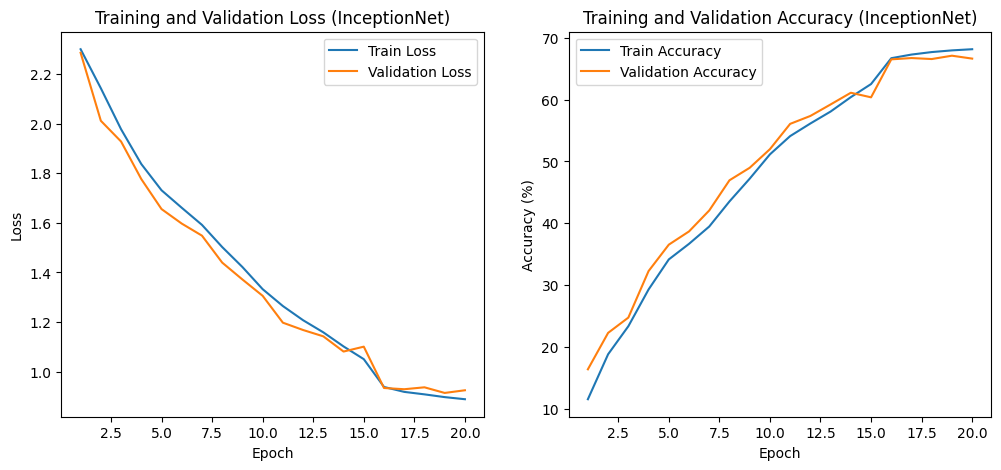

In [35]:

# Plot training and validation results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (InceptionNet)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (InceptionNet)')
plt.legend()

plt.show()

### Model 2 - increasing layer complexity, adjusting batchsize and LR, increasing number of epochs

In [17]:
class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Inception modules
        self.inception1 = InceptionModule(64, 32, 32, 64, 16, 32, 32)
        self.inception2 = InceptionModule(160, 64, 48, 96, 24, 64, 64)
        
        # Down-sample with a max pool layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Additional Inception modules
        self.inception3 = InceptionModule(288, 64, 64, 128, 32, 64, 64)
        self.inception4 = InceptionModule(320, 128, 80, 160, 48, 96, 96)
        
        # New Inception modules for added depth
        self.inception5 = InceptionModule(480, 128, 96, 192, 64, 128, 128)
        self.inception6 = InceptionModule(576, 160, 112, 224, 64, 128, 128)

        # Global average pooling, dropout, and fully connected layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(640, num_classes)  # Updated to match output channels of inception6


    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.inception1(x)
        
        x = self.inception2(x)
        
        x = self.maxpool(x)
        
        x = self.inception3(x)
        
        x = self.inception4(x)
        
        x = self.inception5(x)
        
        x = self.inception6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.fc(x)
        return x



In [18]:
# Hyperparameters
learning_rate = 0.01
batch_size = 128  # Increased batch size
num_epochs = 50
weight_decay = 1e-4      # Weight decay for regularization
# Re-define data loaders with new batch size
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize the updated InceptionNet model, criterion, optimizer, and scheduler
model = InceptionNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=50, gamma=0.05)


In [19]:
# Training and validation loop (reuse previous train and validate functions)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize variables to track the highest accuracy
best_train_accuracy = 0.0
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and validate
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check and update highest training accuracy
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy

    # Check and update highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Print highest accuracies so far
    print(f"Highest Train Accuracy so far: {best_train_accuracy:.2f}%")
    print(f"Highest Val Accuracy so far: {best_val_accuracy:.2f}%\n")

# After training, print the final highest accuracies
print("Training complete.")
print(f"Final Highest Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Final Highest Val Accuracy: {best_val_accuracy:.2f}%")



Epoch 1/50
Epoch 1 - Train Loss: 2.3029, Train Accuracy: 9.79%
Epoch 1 - Val Loss: 2.3025, Val Accuracy: 9.94%
Highest Train Accuracy so far: 9.79%
Highest Val Accuracy so far: 9.94%

Epoch 2/50
Epoch 2 - Train Loss: 2.3026, Train Accuracy: 10.38%
Epoch 2 - Val Loss: 2.3024, Val Accuracy: 11.96%
Highest Train Accuracy so far: 10.38%
Highest Val Accuracy so far: 11.96%

Epoch 3/50
Epoch 3 - Train Loss: 2.3019, Train Accuracy: 10.46%
Epoch 3 - Val Loss: 2.3007, Val Accuracy: 12.56%
Highest Train Accuracy so far: 10.46%
Highest Val Accuracy so far: 12.56%

Epoch 4/50
Epoch 4 - Train Loss: 2.2845, Train Accuracy: 13.01%
Epoch 4 - Val Loss: 2.2234, Val Accuracy: 17.01%
Highest Train Accuracy so far: 13.01%
Highest Val Accuracy so far: 17.01%

Epoch 5/50
Epoch 5 - Train Loss: 2.1061, Train Accuracy: 17.93%
Epoch 5 - Val Loss: 2.0172, Val Accuracy: 18.59%
Highest Train Accuracy so far: 17.93%
Highest Val Accuracy so far: 18.59%

Epoch 6/50
Epoch 6 - Train Loss: 1.9682, Train Accuracy: 19.87%


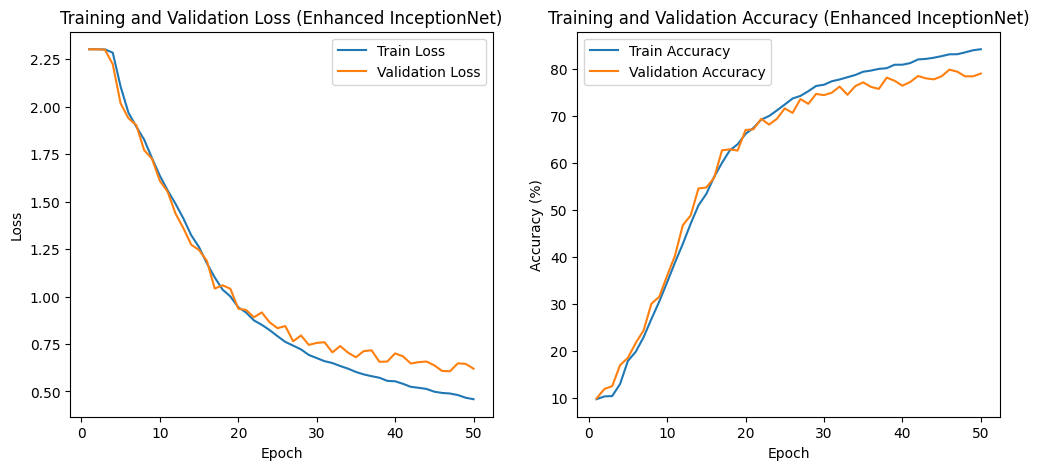

In [20]:
# Plot training and validation results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Enhanced InceptionNet)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (Enhanced InceptionNet)')
plt.legend()

plt.show()

## Best Models comparison

          Model  Train Accuracy (%)  Validation Accuracy (%)
0     ResNet-18               96.03                    88.66
1     MobileNet               82.46                    78.78
2  InceptionNet               84.19                    79.85


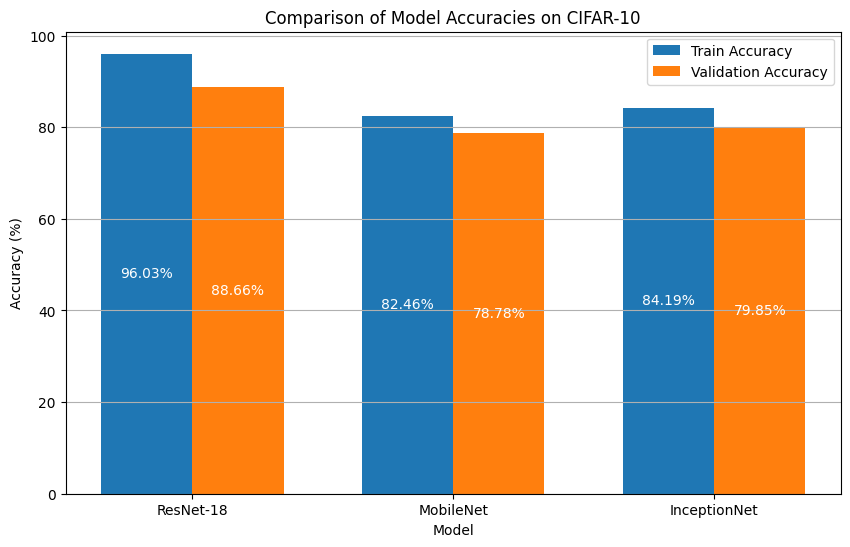

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for models
model_data = {
    'Model': ['ResNet-18', 'MobileNet', 'InceptionNet'],
    'Train Accuracy (%)': [96.03, 82.46, 84.19],
    'Validation Accuracy (%)': [88.66, 78.78, 79.85]
}

# Create DataFrame
df = pd.DataFrame(model_data)

# Display table
print(df)

# Plotting
plt.figure(figsize=(10, 6))

# Bar chart with side-by-side bars for train and validation accuracy
bar_width = 0.35
x = range(len(df['Model']))

# Train accuracy bars
train_bars = plt.bar(x, df['Train Accuracy (%)'], width=bar_width, label='Train Accuracy', align='center')
# Validation accuracy bars, shifted to the right
val_bars = plt.bar([p + bar_width for p in x], df['Validation Accuracy (%)'], width=bar_width, label='Validation Accuracy', align='center')

# Adding accuracy values in the middle of each bar
for bar in train_bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,  # Positioning text in the middle of the bar
        f'{bar.get_height():.2f}%',
        ha='center',
        va='center',
        color='white'
    )

for bar in val_bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f'{bar.get_height():.2f}%',
        ha='center',
        va='center',
        color='white'
    )

# X-axis labels
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies on CIFAR-10')
plt.xticks([p + bar_width / 2 for p in x], df['Model'])

# Legend and grid
plt.legend()
plt.grid(axis='y')

# Show plot
plt.show()


## Test evaluation of the best model (Resnet-18)

Confusion Matrix:
 [[892   2  47   9  10   0   8  10  18   4]
 [ 10 943   3   3   1   1   7   2  10  20]
 [ 16   1 835  32  44  12  33  23   2   2]
 [ 14   0  39 790  42  44  36  30   4   1]
 [  4   0  25  20 901   9  14  26   1   0]
 [  6   0  10 153  24 750  14  41   1   1]
 [  4   0  18  19  13   3 935   5   2   1]
 [  1   0  10  13  17   5   0 952   0   2]
 [ 29   6   5   8   1   0   2   1 938  10]
 [ 14  37   4   7   3   0   8   7  10 910]]
Classification Report:
               precision    recall  f1-score   support

    airplane     0.9010    0.8920    0.8965      1000
  automobile     0.9535    0.9430    0.9482      1000
        bird     0.8384    0.8350    0.8367      1000
         cat     0.7495    0.7900    0.7692      1000
        deer     0.8532    0.9010    0.8765      1000
         dog     0.9102    0.7500    0.8224      1000
        frog     0.8846    0.9350    0.9091      1000
       horse     0.8678    0.9520    0.9080      1000
        ship     0.9513    0.9380    0.

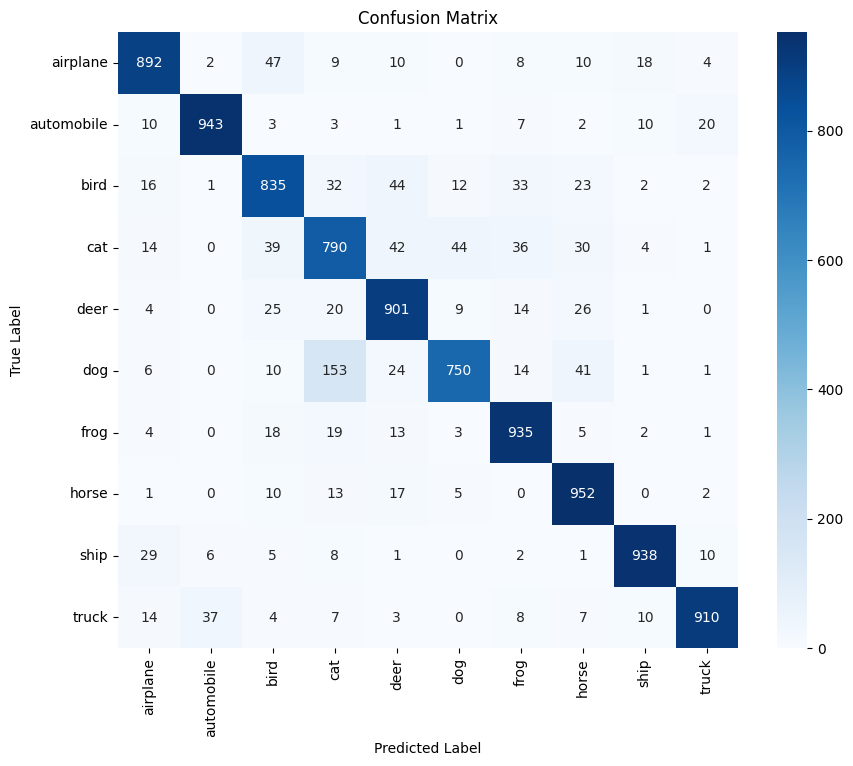

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# Function to calculate accuracy for each label and generate the confusion matrix
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Calculate and display classification report (accuracy per label)
    class_report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Classification Report:\n", class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run the test model function
test_model(model, test_loader, device)
